## MOSAIKS feature extraction

This tutorial demonstrates the **MOSAIKS** method for extracting _feature vectors_ from satellite imagery patches for use in downstream modeling tasks. It will show:
- How to extract 1km$^2$ patches of Sentinel 2 or Landsat multispectral imagery for a list of latitude, longitude points
- How to extract summary features from each of these imagery patches
- How to use the summary features in a linear model of the population density at each point

### Background

Consider the case where you have a dataset of latitude and longitude points assosciated with some dependent variable (for example: population density, weather, housing prices, biodiversity) and, potentially, other independent variables. You would like to model the dependent variable as a function of the independent variables, but instead of including latitude and longitude directly in this model, you would like to include some high dimensional representation of what the Earth looks like at that point (that hopefully explains some of the variance in the dependent variable!). From the computer vision literature, there are various [representation learning techniques](https://en.wikipedia.org/wiki/Feature_learning) that can be used to do this, i.e. extract _features vectors_ from imagery. This notebook gives an implementation of the technique described in [Rolf et al. 2021](https://www.nature.com/articles/s41467-021-24638-z), "A generalizable and accessible approach to machine learning with global satellite imagery" called Multi-task Observation using Satellite Imagery & Kitchen Sinks (**MOSAIKS**). For more information about **MOSAIKS** see the [project's webpage](http://www.globalpolicy.science/mosaiks).

### Environment setup
This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
- If you're running this on the [Planetary Computer Hub](http://planetarycomputer.microsoft.com/compute), make sure to choose the **GPU - PyTorch** profile when presented with the form to choose your environment.
- The Planetary Computer Hub is pre-configured to use your API key.
- To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `pc.settings.set_subscription_key(<YOUR API Key>)`.
    
**Notes**:
- This example uses either
    - [sentinel-2-l2a data](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
    - [landsat-c2-l2 data](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)
- The techniques used here apply equally well to other remote-sensing datasets.

In [2]:
# !pip install -q git+https://github.com/geopandas/dask-geopandas
!pip install -q pyhere

In [4]:
import warnings
import time
import os
import gc
import calendar
import re

RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyhere import here

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import xarray as xr
import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas
import dask_geopandas
from dask.distributed import Client

from pystac import Item
import stackstac
import pyproj

warnings.filterwarnings(action="ignore", category=UserWarning, module="torch")
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

import pystac_client
import planetary_computer as pc


# Disabling the benchmarking feature with torch.backends.cudnn.benchmark = False 
# causes cuDNN to deterministically select an algorithm, possibly at the cost of reduced performance.
# https://pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.benchmark = False

np.random.seed(42)
torch.manual_seed(42)

import random
random.seed(42)

## Set Parameters

In [5]:
num_features = 1024
country_code = 'ZMB'
use_file = True
# use_file = False

In [6]:
satellite = "landsat-c2-l2"
bands = [
    "red",
    "green", 
    "blue",
    # "nir08",
    # "swir16",
    # "swir22"
]

In [7]:
# satellite = "sentinel-2-l2a"
# bands = [  # Sentinel-2 Bands
#     "B02", # B02 (blue) 10 meter
#     "B03", # B03 (green) 10 meter
#     "B04", # B04 (red) 10 meter
#     "B05", # B05(Veg Red Edge 1) 20 meter
#     "B06", # B06(Veg Red Edge 2) 20 meter
#     "B07", # B07(Veg Red Edge 3) 20 meter
#     "B08", # B08 (NIR) 10 meter
#     "B11", # B11 (SWIR (1.6)) 20 meter
#     "B12", # B12 (SWIR (2.2)) 20 meter
# ]

In [8]:
if satellite == "landsat-c2-l2":
    resolution = 30
    min_image_edge = 6
else:
    resolution = 10
    min_image_edge = 20

In [9]:
# dat_re = re.compile(r'\d+') 
# l = [str(int(dat_re.search(x).group())) for x in bands if dat_re.search(x)]
# bands_short = '-'.join(l)

In [10]:
channels = len(bands)
bands_short = "r-g-b-nir-swir16-swir22"

## Create grid and sample points to featurize

In [11]:
if use_file:
    gdf = pd.read_feather(here('data', 'grid', 'ZMB_crop_weights_20k-points.feather'))
    gdf = (
        geopandas
        .GeoDataFrame(
            gdf, 
            geometry = geopandas.points_from_xy(x = gdf.lon, y = gdf.lat), 
            crs='EPSG:4326')
    )
else:
    cell_size = 0.01  # Roughly 1 km
    ### get country shape
    country_file_name = f"data/geo_boundaries/africa_adm0.geojson"
    africa = geopandas.read_file(country_file_name)
    country = africa[africa.adm0_a3 == country_code]
    #### This would be simpler, but throws an error down the line if used 
    # world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    # country = world.query(f'iso_a3 == "{country_code}"')
    ### Create grid of points
    cell_size = .01  # Very roughly 1 km
    xmin, ymin, xmax, ymax = country.total_bounds
    xs = list(np.arange(xmin, xmax + cell_size, cell_size))
    ys = list(np.arange(ymin, ymax + cell_size, cell_size))
    def make_cell(x, y, cell_size):
        ring = [
            (x, y),
            (x + cell_size, y),
            (x + cell_size, y + cell_size),
            (x, y + cell_size)
        ]
        cell = shapely.geometry.Polygon(ring).centroid
        return cell
    center_points = []
    for x in xs:
        for y in ys:
            cell = make_cell(x, y, cell_size)
            center_points.append(cell)
    ### Put grid into a GeDataFrame for cropping to country shape
    gdf = geopandas.GeoDataFrame({'geometry': center_points}, crs = 'EPSG:4326')
    gdf['lon'], gdf['lat'] = gdf.geometry.x, gdf.geometry.y
    ### Subset to country 
    ### This buffer ensures that no points are take at the border 
    ### which would lead to duplication with neighboring countries
    gdf = gdf[gdf.within(country.unary_union.buffer(-0.005))]
    gdf = gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)
    gdf = gdf.sample(frac = 0.1, random_state=42, ignore_index=False)
    points = gdf[["lon", "lat"]].to_numpy()
pt_len = gdf.shape[0]
gdf.shape

(19598, 4)

First we define the pytorch model that we will use to extract the features and a helper method. The **MOSAIKS** methodology describes several ways to do this and we use the simplest.

In [12]:
class RCF(nn.Module):
    """A model for extracting Random Convolution Features (RCF) from input imagery."""
    def __init__(self, num_features=16, kernel_size=3, num_input_channels=channels):
        super(RCF, self).__init__()
        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0, "Please enter an even number of features."
        # Applies a 2D convolution over an input image composed of several input planes.
        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )
        # Fills the input Tensor 'conv1.weight' with values drawn from the normal distribution
        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        # Fills the input Tensor 'conv1.bias' with the value 'val = -1'.
        nn.init.constant_(self.conv1.bias, -1.0)
    def forward(self, x):
        # The rectified linear activation function or ReLU for short is a piecewise linear function 
        # that will output the input directly if it is positive, otherwise, it will output zero.
        x1a = F.relu(self.conv1(x), inplace=True)
        # The below step is where we take the inverse which is appended later
        x1b = F.relu(-self.conv1(x), inplace=True)
        # Applies a 2D adaptive average pooling over an input signal composed of several input planes.
        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()
        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)

Next, we initialize the model and pytorch components

In [13]:
device = torch.device("cuda")
model = RCF(num_features).eval().to(device)

### Extract features from the imagery around each point

We need to find a suitable Sentinel 2 scene for each point. As usual, we'll use `pystac-client` to search for items matching some conditions, but we don't just want do make a `.search()` call for each of the 67,968 remaining points. Each HTTP request is relatively slow. Instead, we will *batch* or points and search *in parallel*.

We need to be a bit careful with how we batch up our points though. Since a single Sentinel 2 scene will cover many points, we want to make sure that points which are spatially close together end up in the same batch. In short, we need to spatially partition the dataset. This is implemented in `dask-geopandas`.

So the overall workflow will be

1. Find an appropriate STAC item for each point (in parallel, using the spatially partitioned dataset)
2. Feed the points and STAC items to a custom Dataset that can read imagery given a point and the URL of a overlapping S2 scene
3. Use a custom Dataloader, which uses our Dataset, to feed our model imagery and save the corresponding features

In [14]:
NPARTITIONS = 250

ddf = dask_geopandas.from_geopandas(gdf, npartitions=1)
hd = ddf.hilbert_distance().compute()
gdf["hd"] = hd
gdf = gdf.sort_values("hd")

dgdf = dask_geopandas.from_geopandas(gdf, npartitions=NPARTITIONS, sort=False)

del ddf
del hd
del gdf
gc.collect()

0

In [15]:
year_start = 2012
year_end = 2012

buffer_size = 0.005
cloud_limit = 20

batch_size = 30
workers = os.cpu_count()

In [16]:
def query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull)

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search_start = f"2012-02-1" 
    search_end = f"2012-02-28" 

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=[satellite],  
        intersects=intersects,
        datetime=[search_start, search_end],
        query={"eo:cloud_cover": {"lt": cloud_limit}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()
    features = ic["features"]
    features_d = {item["id"]: item for item in features}
    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }
    index = []
    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])
    items = geopandas.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()
    point_items = []
    point_items2 = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by) == 1:
            point_items.append(features_d[covered_by.index[0]])
            point_items2.append(None)
        elif len(covered_by) > 1:
            point_items.append(features_d[covered_by.index[0]])
            point_items2.append(features_d[covered_by.index[1]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)
            point_items2.append(None)
    return points.assign(stac_item=point_items, 
                         stac_item2=point_items2
                        )

In [17]:
with Client(n_workers=16) as client:
    meta = dgdf._meta.assign(stac_item=[], 
                             stac_item2 =[]
                            )
    df2 = dgdf.map_partitions(query, meta=meta).compute()
# df3 = df2.dropna(subset=["stac_item"]).reset_index(drop = True)
df3 = df2.dropna(subset=["stac_item2"]).reset_index(drop = True)

matching_items = []
for item in df3.stac_item.tolist():
    signed_item = pc.sign(Item.from_dict(item))
    matching_items.append(signed_item)
    
matching_items2 = []
for item in df3.stac_item2.tolist():
    signed_item = pc.sign(Item.from_dict(item))
    matching_items2.append(signed_item)

points = df3[["lon", "lat"]].to_numpy()
len(points)

25

In [120]:
# df2[df2.stac_item2.notnull()]

In [18]:
from scipy import ndimage as nd

def fill(data, invalid=None):
    """
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. 
                 data value are replaced where invalid is True
                 If None (default), use: invalid = np.isnan(data)

    Output: 
        Return a filled array. 
    """    
    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(
        invalid, 
        return_distances=False, 
        return_indices=True
    )
    return data[tuple(ind)]

In [20]:
# class CustomDataset(Dataset):
#     def __init__(self, points, items, items2, buffer=buffer_size):
#         self.points = points
#         self.items = items
#         self.items2 = items2
#         self.buffer = buffer

#     def __len__(self):
#         return self.points.shape[0]

#     def __getitem__(self, idx):

#         lon, lat = self.points[idx]
#         fn = (self.items[idx], self.items2[idx])
        

#         if fn is None:
#             return None
#         else:
#             try:
#                 stack = stackstac.stack(
#                     items = fn,
#                     assets=bands,
#                     resolution=resolution,
#                 )
#                 # stack2 = stackstac.stack(
#                 #     items = fn2,
#                 #     assets=bands,
#                 #     resolution=resolution,
#                 # )
#                 # stack = stack1.combine_first(stack2).median("time", keep_attrs=True)
#                 # stack = xr.combine_by_coords([stack1, stack2])
#                 # stack = xr.merge([stack1, stack2], compat="no_conflicts")
#                 # stack = xr.combine_first([stack1, stack2])
                
#                 x_min, y_min = pyproj.Proj(stack.crs)(lon-self.buffer, lat-self.buffer)
#                 x_max, y_max = pyproj.Proj(stack.crs)(lon+self.buffer, lat+self.buffer)
#                 aoi = stack.loc[..., y_max:y_min, x_min:x_max]
               
#                 out_image = aoi.data 
#                 # out_image = fill(data.data)
#                 out_image = ((out_image - np.nanmin(out_image) ) / (np.nanmax(out_image) - np.nanmin(out_image)))
                
#                 out_image = out_image.compute(
#                     scheduler="single-threaded"
#                     )
#             except ValueError:
#                 pass
#             out_image = torch.from_numpy(out_image).float()
#             return stack

In [77]:
class CustomDataset(Dataset):
    def __init__(self, points, items, buffer=buffer_size):
        self.points = points
        self.items = items
        self.buffer = buffer

    def __len__(self):
        return self.points.shape[0]

    def __getitem__(self, idx):

        lon, lat = self.points[idx]
        fn = self.items[idx]

        if fn is None:
            return None
        else:
            try:
                stack = stackstac.stack(
                    items = fn, 
                    assets=bands,
                    resolution=resolution,
                )
                x_min, y_min = pyproj.Proj(stack.crs)(lon-self.buffer, lat-self.buffer)
                x_max, y_max = pyproj.Proj(stack.crs)(lon+self.buffer, lat+self.buffer)
                aoi = stack.loc[..., y_max:y_min, x_min:x_max]
               
                data = aoi.compute(
                    scheduler="single-threaded"
                    )
                # out_image = data.data 
                out_image = fill(data.data)
                out_image = ((out_image - np.nanmin(out_image) ) / (np.nanmax(out_image) - np.nanmin(out_image)))
            except ValueError:
                pass
            out_image = torch.from_numpy(out_image).float()
            return out_image

In [78]:
dataset = CustomDataset(points, matching_items, buffer = 0.015)

In [79]:
# dataset[0]

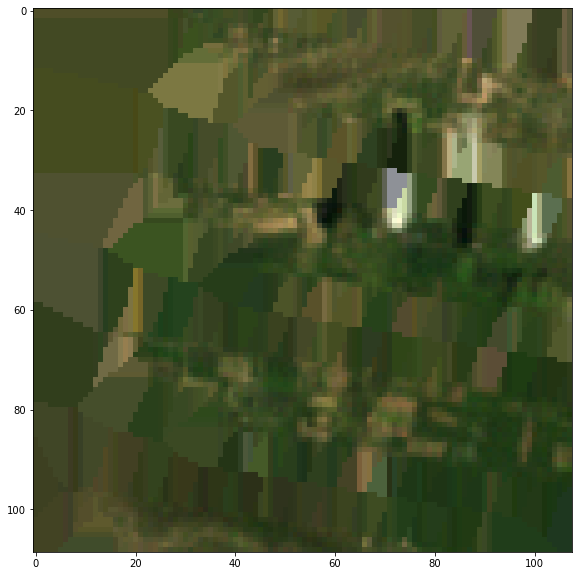

In [80]:
img = dataset[0].numpy()
img = np.rollaxis(img.squeeze(), 0, 3)
plt.figure(figsize = (10, 10))
plt.imshow(img)
plt.show()
plt.close()

In [109]:
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    collate_fn=lambda x: x,
    pin_memory=False,
)

In [110]:
x_all = np.zeros((points.shape[0], num_features), dtype=float)
tic = time.time()
toc = time.time()
i = 0
for images in dataloader:
    for image in images:

        if i % 1000 == 0:
            print(
                f"{i}/{points.shape[0]} -- {i / points.shape[0] * 100:0.2f}%"
                + f" -- {time.time()-tic:0.2f} seconds"
            )
            tic = time.time()

        if image is not None:
            assert len(image.shape) == 4, image.shape[0] == 1
            # if type(image) == torch.Tensor: 
            try:
                if image.shape[2] >= min_image_edge and image.shape[3] >= min_image_edge:
                    image = image.to(device)
                    with torch.no_grad():
                        feats = model(image).cpu().numpy()
                    x_all[i] = feats
                else:
                    pass
            except ValueError: 
                pass 
        else:
            pass  # this happens if we do not find a S2 scene for some point
        i += 1


        torch.cuda.empty_cache()

    torch.cuda.empty_cache()

0/758 -- 0.00% -- 17.07 seconds


In [111]:
features_monthly = pd.DataFrame(x_all)
features_monthly[["lon", "lat"]] = points.tolist()
# features_monthly['year'] = yr
# features_monthly['month'] = mn

In [112]:
features_monthly

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,lon,lat
0,0.0,0.447948,0.0,1.303768,1.783593,0.001066,0.069645,1.029143,0.360674,1.938398,...,0.617046,0.013426,2.397793,2.337935,1.960293,0.002190,4.655385,0.005369,23.574878,-16.674232
1,0.0,0.520879,0.0,1.199657,1.345519,0.000258,0.011991,0.730896,0.281851,1.503808,...,0.542221,0.220323,2.360501,2.105009,1.756452,0.002314,3.625113,0.086868,23.584878,-16.674232
2,0.0,0.269661,0.0,0.611145,0.838936,0.008700,0.019745,0.328593,0.047832,1.014019,...,0.564341,0.316510,1.714391,1.742387,1.567845,0.025872,2.985596,0.159931,23.684878,-16.724232
3,0.0,0.377385,0.0,1.036430,1.350072,0.000667,0.036379,0.785428,0.221734,1.473903,...,0.609555,0.234743,2.181445,2.088584,1.765673,0.058305,3.758696,0.168027,23.554878,-16.624232
4,0.0,0.284213,0.0,0.697927,1.357353,0.000000,0.411349,0.640151,0.193188,1.869843,...,0.893661,0.000090,1.644531,1.869496,1.837644,0.000000,4.721381,0.000000,23.594878,-16.664232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,0.0,0.630938,0.0,1.110620,1.596393,0.000000,0.358305,0.413183,0.130399,2.396557,...,0.486602,0.000000,1.422560,1.695645,1.803615,0.000000,4.791719,0.000000,28.364878,-16.514232
754,0.0,0.665666,0.0,1.087320,1.610986,0.000000,0.355626,0.438745,0.135259,2.414023,...,0.548764,0.002064,1.406011,1.738917,1.870140,0.000000,4.755852,0.000000,28.364878,-16.504232
755,0.0,0.764531,0.0,1.436793,1.907715,0.000000,0.250044,0.717566,0.283883,2.547054,...,0.616957,0.000108,1.904832,2.052500,2.022559,0.000000,5.039641,0.000000,28.414878,-16.474232
756,0.0,1.308655,0.0,1.566869,1.959789,0.000000,0.234685,0.405963,0.050886,2.725920,...,0.126932,0.000346,0.930988,1.715796,1.856489,0.000000,4.579545,0.000000,28.434878,-16.454232


In [39]:
len(matching_items)

758

In [16]:
matching_items[1]

<Item id=LE07_L2SP_175072_20120106_02_T1>

In [17]:
matching_items = []
for item in df3.stac_item.tolist():
    signed_item = pc.sign(Item.from_dict(item))
    matching_items.append(signed_item)

In [18]:
df3.stac_item

0      {'id': 'LE07_L2SP_175072_20120106_02_T1', 'bbo...
1      {'id': 'LE07_L2SP_175072_20120106_02_T1', 'bbo...
2      {'id': 'LE07_L2SP_175072_20120106_02_T1', 'bbo...
3      {'id': 'LE07_L2SP_175072_20120106_02_T1', 'bbo...
4      {'id': 'LE07_L2SP_175072_20120106_02_T1', 'bbo...
                             ...                        
753    {'id': 'LE07_L2SP_171072_20120110_02_T1', 'bbo...
754    {'id': 'LE07_L2SP_171072_20120110_02_T1', 'bbo...
755    {'id': 'LE07_L2SP_171072_20120110_02_T1', 'bbo...
756    {'id': 'LE07_L2SP_171072_20120110_02_T1', 'bbo...
757    {'id': 'LE07_L2SP_171072_20120110_02_T1', 'bbo...
Name: stac_item, Length: 758, dtype: object

In [22]:
# next(iter(df3.stac_item))

In [36]:
# for i in df3.index:
#     print(len(df3.stac_item.tolist()[i]))